In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

from trainer import *

from deepr import DeepR

import pickle

In [2]:

print("Feedforward SNN Trained on MNIST (latency encoded)")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=256
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_sampler = torch.utils.data.RandomSampler(mnist_train, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(mnist_test, generator=gtest,replacement=False)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False,drop_last=False,pin_memory=True,sampler=train_sampler,num_workers=1)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,drop_last=False,pin_memory=True,sampler=test_sampler,num_workers=1)

Feedforward SNN Trained on MNIST (latency encoded)
Using device: cuda


In [3]:
################ MNIST Model ##############################################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 300
num_hidden2 = 100
num_outputs = 10
num_steps = 26  # for spike encoding
beta = 0.95 #leak rate
lr=5e-3

spike_grad1 = surrogate.atan() 

class Net(nn.Module):

    def __init__(self,c=None):
        super().__init__()

        self.loss = functional.ce_temporal_loss()
        self.accuracy_metric = functional.accuracy_temporal

        #initialise neuron connections
        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1,num_hidden2),
            nn.Linear(num_hidden2,num_outputs)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList([
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1)
        ])


        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).
        self.to(device)

        if c is not None:
            self.deepr = DeepR(self.linears,lr,[0,1,2],connectivity=c,device=device)
  
    def forward(self,x): #x is input data

        x=x.view(x.size(0), -1) #flatten image
        
        #spike encoding at input layer
        x_spk = spikegen.latency(x,num_steps=num_steps) 
        # Initialize hidden states
        mem1 = self.neurons[0].init_leaky()
        mem2 = self.neurons[1].init_leaky()
        mem3 = self.neurons[2].init_leaky()
        
        # record spike outputs and membrane potentials
        spk3_rec = []

        for step in range(num_steps):
            x = x_spk[step] #for encoded input

            cur1 = self.linears[0](x)
            spk1, mem1 = self.neurons[0](cur1, mem1)

            cur2 = self.linears[1](spk1)
            spk2, mem2 = self.neurons[1](cur2, mem2)

            cur3 = self.linears[2](spk2)
            spk3, mem3 = self.neurons[2](cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)
    
###################################################################################



Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 10.48
Validation accuracy: 9.77%
Training accuracy: 12.89%
----------------
Iteration: 50
Training loss: 0.82
Validation loss: 0.76
Validation accuracy: 80.47%
Training accuracy: 82.03%
----------------
Iteration: 100
Training loss: 0.41
Validation loss: 0.35
Validation accuracy: 89.06%
Training accuracy: 87.50%
----------------
Iteration: 150
Training loss: 0.31
Validation loss: 0.35
Validation accuracy: 89.45%
Training accuracy: 91.02%
----------------
Iteration: 200
Training loss: 0.25
Validation loss: 0.19
Validation accuracy: 92.58%
Training accuracy: 92.19%
----------------
Iteration: 250
Training loss: 0.14
Validation loss: 0.26
Validation accuracy: 92.97%
Training accuracy: 95.70%
----------------
Iteration: 300
Training loss: 0.21
Validation loss: 0.19
Validation accuracy: 95.31%
Training accuracy: 93.36%
----------------
Iteration: 350
Training loss: 0.12
Validation loss: 0.14
Validation accuracy: 93.75%
Training accuracy: 97.

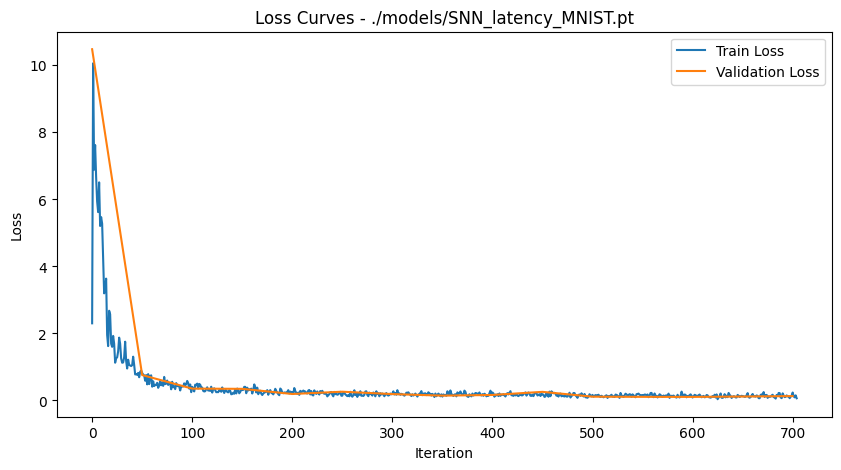

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.94%
----


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 7.85
Validation loss: 9.87
Validation accuracy: 12.89%
Training accuracy: 11.33%
----------------
Iteration: 50
Training loss: 2.04
Validation loss: 2.11
Validation accuracy: 21.09%
Training accuracy: 22.27%
----------------
Iteration: 100
Training loss: 2.21
Validation loss: 1.88
Validation accuracy: 28.12%
Training accuracy: 21.48%
----------------
Iteration: 150
Training loss: 2.12
Validation loss: 1.74
Validation accuracy: 66.80%
Training accuracy: 57.03%
----------------
Iteration: 200
Training loss: 0.37
Validation loss: 0.35
Validation accuracy: 87.50%
Training accuracy: 87.89%
----------------
Iteration: 250
Training loss: 0.27
Validation loss: 0.39
Validation accuracy: 89.06%
Training accuracy: 92.19%
----------------
Iteration: 300
Training loss: 0.26
Validation loss: 0.27
Validation accuracy: 91.02%
Training accuracy: 91.41%
----------------
Iteration: 350
Training loss: 0.17
Validation loss: 0.18
Validation accuracy: 94.92%
Training accuracy: 95.

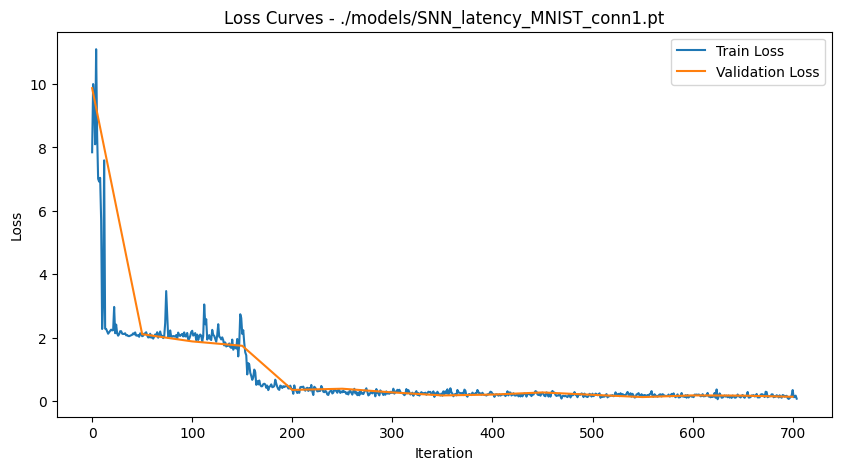

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.40%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 7.76
Validation loss: 10.32
Validation accuracy: 9.77%
Training accuracy: 8.20%
----------------
Iteration: 50
Training loss: 0.48
Validation loss: 0.54
Validation accuracy: 81.64%
Training accuracy: 84.77%
----------------
Iteration: 100
Training loss: 0.33
Validation loss: 0.32
Validation accuracy: 89.84%
Training accuracy: 89.45%
----------------
Iteration: 150
Training loss: 0.29
Validation loss: 0.38
Validation accuracy: 87.50%
Training accuracy: 91.41%
----------------
Iteration: 200
Training loss: 0.22
Validation loss: 0.22
Validation accuracy: 91.02%
Training accuracy: 92.97%
----------------
Iteration: 250
Training loss: 0.21
Validation loss: 0.29
Validation accuracy: 94.53%
Training accuracy: 94.92%
----------------
Iteration: 300
Training loss: 0.22
Validation loss: 0.20
Validation accuracy: 94.14%
Training accuracy: 93.36%
----------------
Iteration: 350
Training loss: 0.17
Validation loss: 0.16
Validation accuracy: 94.53%
Training accuracy: 95.7

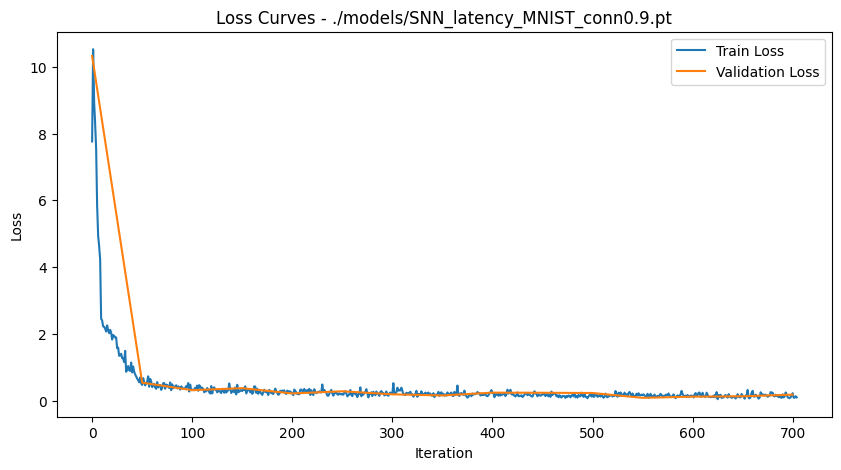

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.76%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 9.95
Validation loss: 2.36
Validation accuracy: 12.50%
Training accuracy: 8.20%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.11%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.05
Validation loss: 2.09
Validation accuracy: 9.38%
Training accuracy: 12.11%
----------------
Iteration: 150
Training loss: 2.13
Validation loss: 2.09
Validation accuracy: 10.55%
Training accuracy: 11.72%
----------------
Iteration: 200
Training loss: 2.10
Validation loss: 2.17
Validation accuracy: 6.64%
Training accuracy: 8.98%
----------------
Iteration: 250
Training loss: 1.80
Validation loss: 1.77
Validation accuracy: 26.95%
Training accuracy: 25.39%
----------------
Iteration: 300
Training loss: 1.79
Validation loss: 1.52
Validation accuracy: 41.41%
Training accuracy: 42.58%
----------------
Iteration: 350
Training loss: 1.13
Validation loss: 1.27
Validation accuracy: 48.83%
Training accuracy: 55.08%


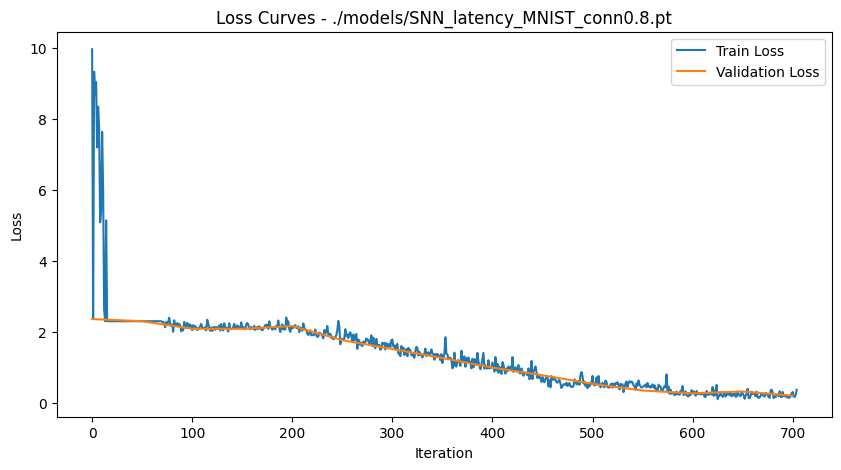

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 93.89%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 9.06
Validation loss: 4.87
Validation accuracy: 7.81%
Training accuracy: 9.38%
----------------
Iteration: 50
Training loss: 2.26
Validation loss: 2.31
Validation accuracy: 13.67%
Training accuracy: 12.50%
----------------
Iteration: 100
Training loss: 1.05
Validation loss: 1.04
Validation accuracy: 76.95%
Training accuracy: 71.88%
----------------
Iteration: 150
Training loss: 0.52
Validation loss: 0.42
Validation accuracy: 90.23%
Training accuracy: 84.38%
----------------
Iteration: 200
Training loss: 0.29
Validation loss: 0.30
Validation accuracy: 91.41%
Training accuracy: 91.02%
----------------
Iteration: 250
Training loss: 0.26
Validation loss: 0.32
Validation accuracy: 91.80%
Training accuracy: 93.36%
----------------
Iteration: 300
Training loss: 0.27
Validation loss: 0.29
Validation accuracy: 92.97%
Training accuracy: 89.84%
----------------
Iteration: 350
Training loss: 0.23
Validation loss: 0.20
Validation accuracy: 93.36%
Training accuracy: 92.97

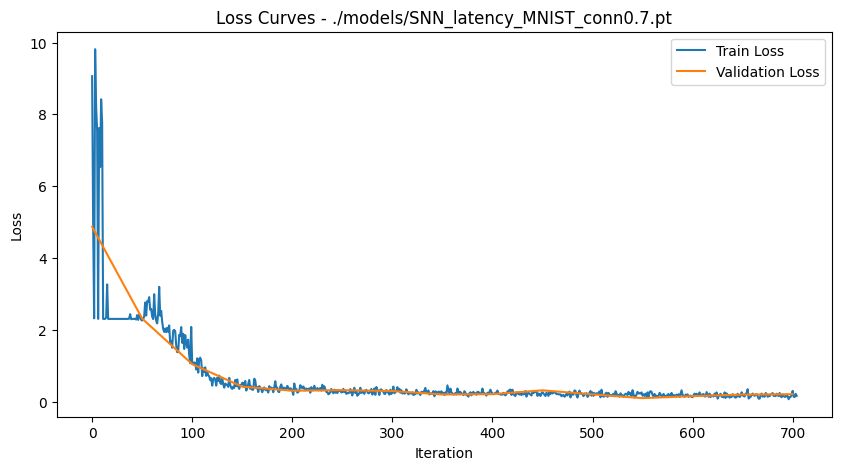

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 94.99%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 8.15
Validation loss: 9.15
Validation accuracy: 12.50%
Training accuracy: 11.33%
----------------
Iteration: 50
Training loss: 1.48
Validation loss: 1.85
Validation accuracy: 61.33%
Training accuracy: 64.45%
----------------
Iteration: 100
Training loss: 0.41
Validation loss: 0.36
Validation accuracy: 90.62%
Training accuracy: 87.50%
----------------
Iteration: 150
Training loss: 0.34
Validation loss: 0.40
Validation accuracy: 88.28%
Training accuracy: 90.23%
----------------
Iteration: 200
Training loss: 0.27
Validation loss: 0.31
Validation accuracy: 89.84%
Training accuracy: 90.23%
----------------
Iteration: 250
Training loss: 0.23
Validation loss: 0.26
Validation accuracy: 92.58%
Training accuracy: 92.58%
----------------
Iteration: 300
Training loss: 0.27
Validation loss: 0.27
Validation accuracy: 92.97%
Training accuracy: 92.58%
----------------
Iteration: 350
Training loss: 0.18
Validation loss: 0.16
Validation accuracy: 93.75%
Training accuracy: 95.

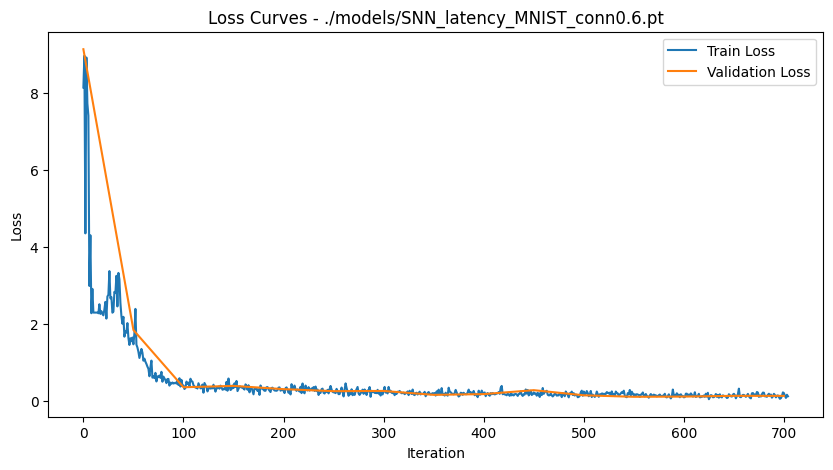

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.54%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 10.59
Validation accuracy: 8.98%
Training accuracy: 12.89%
----------------
Iteration: 50
Training loss: 1.65
Validation loss: 1.80
Validation accuracy: 41.80%
Training accuracy: 46.09%
----------------
Iteration: 100
Training loss: 0.52
Validation loss: 0.42
Validation accuracy: 86.33%
Training accuracy: 83.20%
----------------
Iteration: 150
Training loss: 0.46
Validation loss: 0.36
Validation accuracy: 89.45%
Training accuracy: 84.77%
----------------
Iteration: 200
Training loss: 0.29
Validation loss: 0.28
Validation accuracy: 92.97%
Training accuracy: 90.62%
----------------
Iteration: 250
Training loss: 0.27
Validation loss: 0.34
Validation accuracy: 87.50%
Training accuracy: 93.36%
----------------
Iteration: 300
Training loss: 0.32
Validation loss: 0.21
Validation accuracy: 92.58%
Training accuracy: 91.41%
----------------
Iteration: 350
Training loss: 0.19
Validation loss: 0.23
Validation accuracy: 91.80%
Training accuracy: 95.

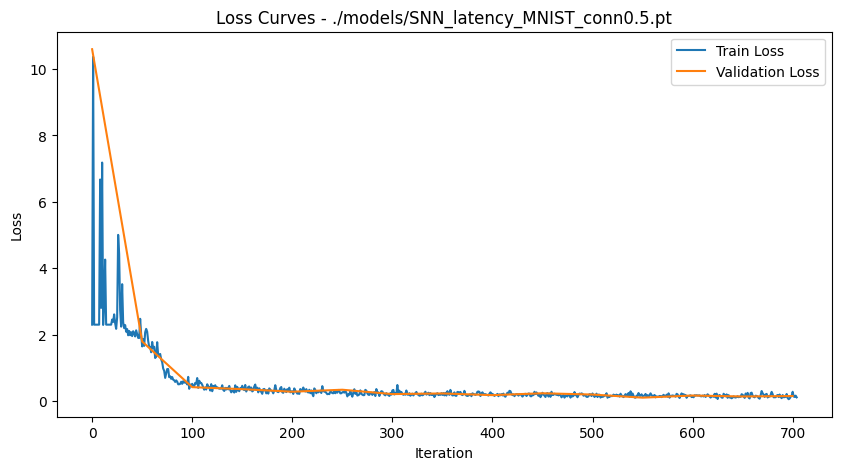

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.32%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 10.07
Validation loss: 7.80
Validation accuracy: 8.98%
Training accuracy: 11.33%
----------------
Iteration: 50
Training loss: 2.32
Validation loss: 2.48
Validation accuracy: 22.27%
Training accuracy: 21.09%
----------------
Iteration: 100
Training loss: 0.63
Validation loss: 0.55
Validation accuracy: 80.47%
Training accuracy: 80.08%
----------------
Iteration: 150
Training loss: 0.48
Validation loss: 0.38
Validation accuracy: 89.45%
Training accuracy: 85.94%
----------------
Iteration: 200
Training loss: 0.27
Validation loss: 0.30
Validation accuracy: 90.62%
Training accuracy: 90.62%
----------------
Iteration: 250
Training loss: 0.23
Validation loss: 0.33
Validation accuracy: 90.23%
Training accuracy: 94.14%
----------------
Iteration: 300
Training loss: 0.34
Validation loss: 0.24
Validation accuracy: 93.36%
Training accuracy: 90.23%
----------------
Iteration: 350
Training loss: 0.16
Validation loss: 0.16
Validation accuracy: 94.92%
Training accuracy: 95.

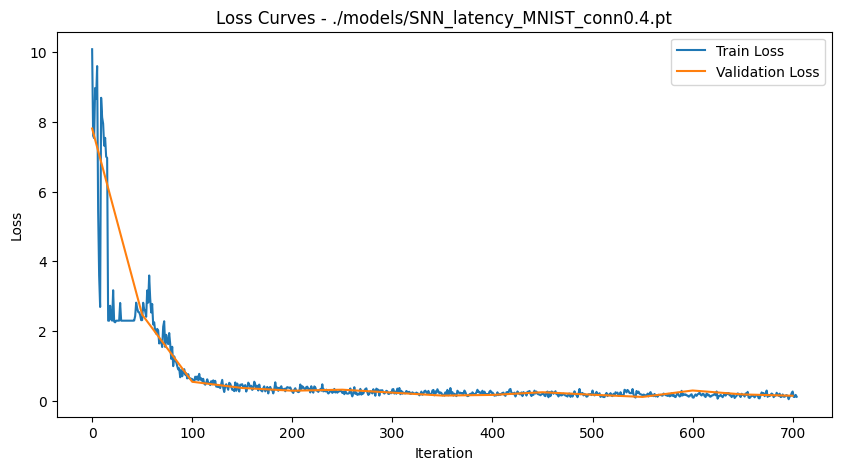

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.22%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.77%
Training accuracy: 12.89%
----------------
Iteration: 50
Training loss: 2.22
Validation loss: 2.11
Validation accuracy: 34.77%
Training accuracy: 28.12%
----------------
Iteration: 100
Training loss: 0.59
Validation loss: 0.50
Validation accuracy: 83.59%
Training accuracy: 82.81%
----------------
Iteration: 150
Training loss: 0.38
Validation loss: 0.43
Validation accuracy: 87.50%
Training accuracy: 87.89%
----------------
Iteration: 200
Training loss: 0.28
Validation loss: 0.27
Validation accuracy: 91.02%
Training accuracy: 91.41%
----------------
Iteration: 250
Training loss: 0.21
Validation loss: 0.27
Validation accuracy: 90.23%
Training accuracy: 94.14%
----------------
Iteration: 300
Training loss: 0.29
Validation loss: 0.23
Validation accuracy: 93.36%
Training accuracy: 90.62%
----------------
Iteration: 350
Training loss: 0.19
Validation loss: 0.18
Validation accuracy: 94.92%
Training accuracy: 92.5

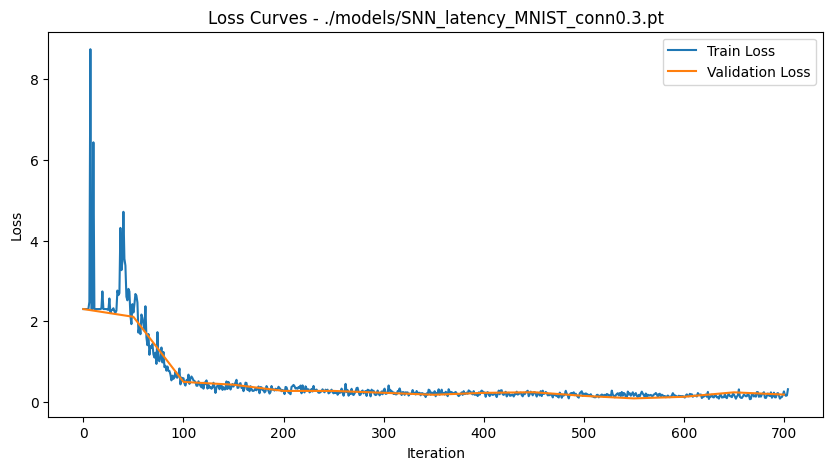

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 95.71%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 3.82
Validation loss: 2.36
Validation accuracy: 9.77%
Training accuracy: 8.20%
----------------
Iteration: 50
Training loss: 2.65
Validation loss: 2.30
Validation accuracy: 26.95%
Training accuracy: 23.05%
----------------
Iteration: 100
Training loss: 0.84
Validation loss: 0.64
Validation accuracy: 78.91%
Training accuracy: 75.78%
----------------
Iteration: 150
Training loss: 0.43
Validation loss: 0.62
Validation accuracy: 81.64%
Training accuracy: 86.72%
----------------
Iteration: 200
Training loss: 0.34
Validation loss: 0.40
Validation accuracy: 89.45%
Training accuracy: 88.28%
----------------
Iteration: 250
Training loss: 0.36
Validation loss: 0.38
Validation accuracy: 88.67%
Training accuracy: 89.45%
----------------
Iteration: 300
Training loss: 0.33
Validation loss: 0.34
Validation accuracy: 91.02%
Training accuracy: 88.28%
----------------
Iteration: 350
Training loss: 0.25
Validation loss: 0.26
Validation accuracy: 91.80%
Training accuracy: 91.80

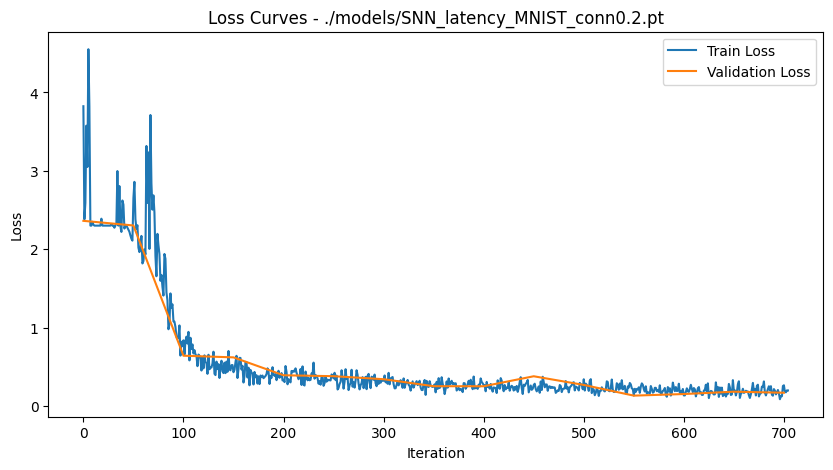

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 94.89%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 8.74
Validation loss: 7.30
Validation accuracy: 10.94%
Training accuracy: 9.38%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.38
Validation accuracy: 6.64%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 1.39
Validation loss: 1.63
Validation accuracy: 47.66%
Training accuracy: 53.12%
----------------
Iteration: 150
Training loss: 0.82
Validation loss: 0.67
Validation accuracy: 80.47%
Training accuracy: 75.78%
----------------
Iteration: 200
Training loss: 0.49
Validation loss: 0.53
Validation accuracy: 84.38%
Training accuracy: 85.16%
----------------
Iteration: 250
Training loss: 0.44
Validation loss: 0.52
Validation accuracy: 84.77%
Training accuracy: 86.33%
----------------
Iteration: 300
Training loss: 0.55
Validation loss: 0.51
Validation accuracy: 85.16%
Training accuracy: 85.94%
----------------
Iteration: 350
Training loss: 0.34
Validation loss: 0.36
Validation accuracy: 89.06%
Training accuracy: 92.58

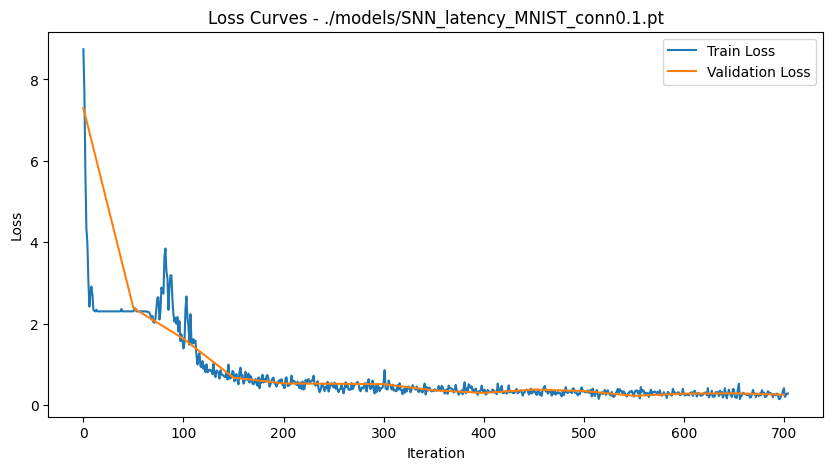

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 92.68%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 6.22
Validation loss: 4.61
Validation accuracy: 8.98%
Training accuracy: 11.33%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.27
Validation accuracy: 16.02%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.44
Validation loss: 3.36
Validation accuracy: 33.98%
Training accuracy: 40.62%
----------------
Iteration: 150
Training loss: 0.82
Validation loss: 0.85
Validation accuracy: 76.17%
Training accuracy: 74.22%
----------------
Iteration: 200
Training loss: 0.56
Validation loss: 0.49
Validation accuracy: 84.38%
Training accuracy: 80.47%
----------------
Iteration: 250
Training loss: 0.42
Validation loss: 0.53
Validation accuracy: 83.98%
Training accuracy: 88.28%
----------------
Iteration: 300
Training loss: 0.49
Validation loss: 0.43
Validation accuracy: 88.28%
Training accuracy: 85.55%
----------------
Iteration: 350
Training loss: 0.46
Validation loss: 0.35
Validation accuracy: 89.06%
Training accuracy: 88.6

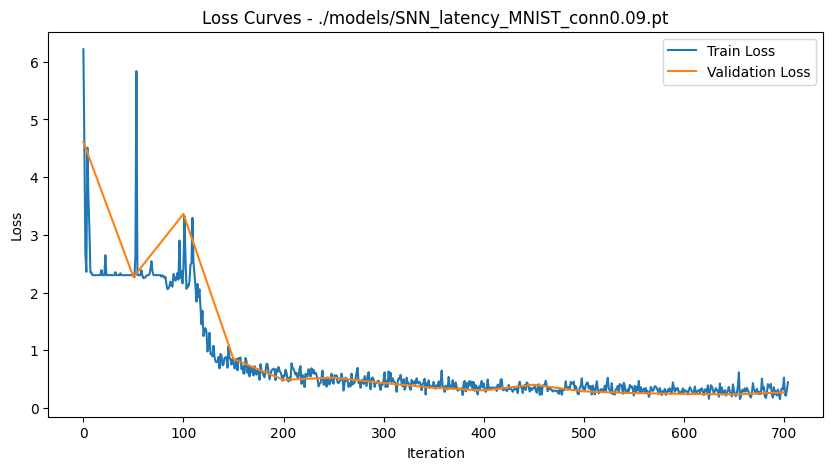

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 91.74%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 6.20
Validation loss: 6.42
Validation accuracy: 10.94%
Training accuracy: 11.33%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.11%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 1.89
Validation loss: 1.91
Validation accuracy: 25.78%
Training accuracy: 30.86%
----------------
Iteration: 150
Training loss: 1.17
Validation loss: 1.25
Validation accuracy: 70.31%
Training accuracy: 71.09%
----------------
Iteration: 200
Training loss: 0.60
Validation loss: 0.60
Validation accuracy: 79.69%
Training accuracy: 80.08%
----------------
Iteration: 250
Training loss: 0.44
Validation loss: 0.55
Validation accuracy: 85.16%
Training accuracy: 85.55%
----------------
Iteration: 300
Training loss: 0.57
Validation loss: 0.44
Validation accuracy: 87.50%
Training accuracy: 84.38%
----------------
Iteration: 350
Training loss: 0.38
Validation loss: 0.35
Validation accuracy: 87.89%
Training accuracy: 92.

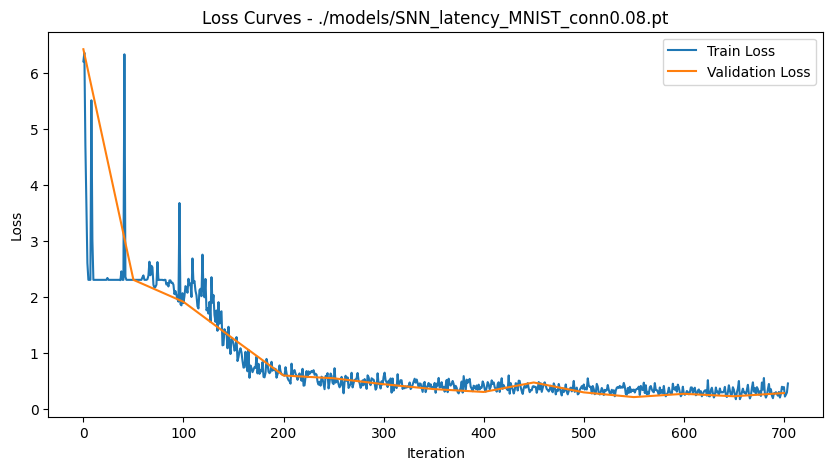

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 91.21%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 8.30
Validation loss: 7.20
Validation accuracy: 10.94%
Training accuracy: 9.38%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.11%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.26
Validation loss: 2.31
Validation accuracy: 24.22%
Training accuracy: 22.27%
----------------
Iteration: 150
Training loss: 1.39
Validation loss: 1.08
Validation accuracy: 73.83%
Training accuracy: 65.23%
----------------
Iteration: 200
Training loss: 0.59
Validation loss: 0.70
Validation accuracy: 76.95%
Training accuracy: 81.25%
----------------
Iteration: 250
Training loss: 0.45
Validation loss: 0.65
Validation accuracy: 77.73%
Training accuracy: 85.55%
----------------
Iteration: 300
Training loss: 0.60
Validation loss: 0.43
Validation accuracy: 85.94%
Training accuracy: 81.64%
----------------
Iteration: 350
Training loss: 0.38
Validation loss: 0.39
Validation accuracy: 87.89%
Training accuracy: 89.0

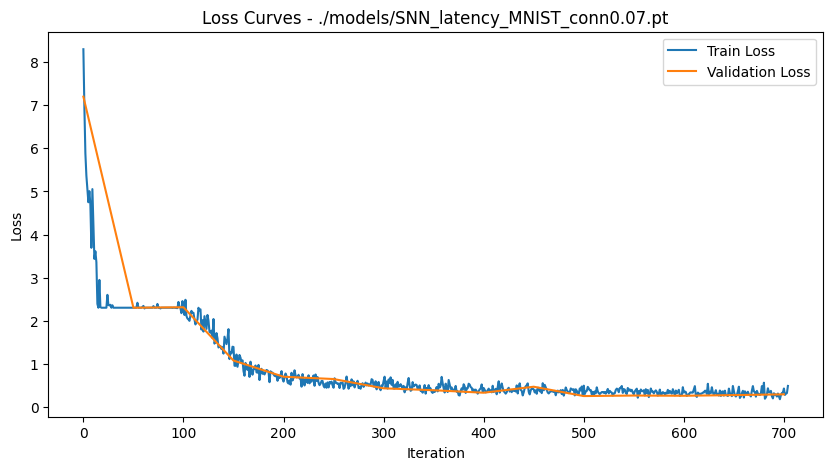

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 91.17%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 10.26
Validation loss: 9.50
Validation accuracy: 7.81%
Training accuracy: 7.03%
----------------
Iteration: 50
Training loss: 3.02
Validation loss: 2.89
Validation accuracy: 10.16%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.92
Validation loss: 2.69
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 150
Training loss: 1.83
Validation loss: 1.69
Validation accuracy: 42.58%
Training accuracy: 41.80%
----------------
Iteration: 200
Training loss: 1.01
Validation loss: 0.86
Validation accuracy: 71.88%
Training accuracy: 67.58%
----------------
Iteration: 250
Training loss: 0.72
Validation loss: 0.71
Validation accuracy: 78.52%
Training accuracy: 76.95%
----------------
Iteration: 300
Training loss: 0.70
Validation loss: 0.66
Validation accuracy: 81.25%
Training accuracy: 78.52%
----------------
Iteration: 350
Training loss: 0.51
Validation loss: 0.48
Validation accuracy: 82.81%
Training accuracy: 85.94%

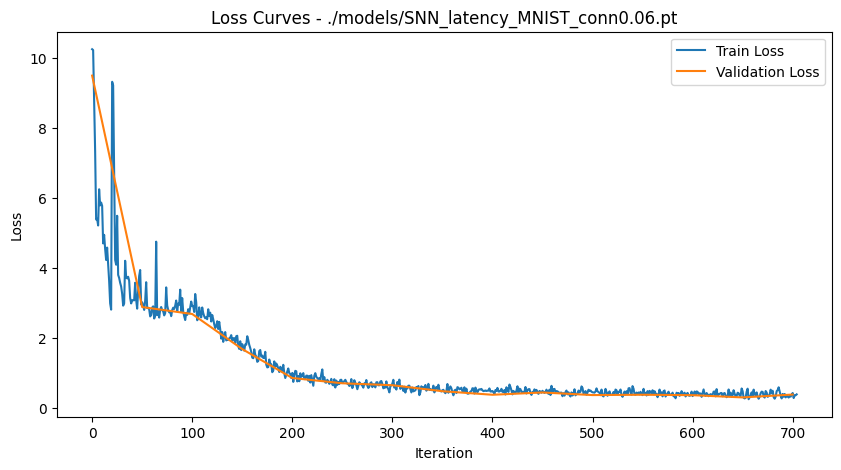

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 87.98%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.60
Validation accuracy: 9.77%
Training accuracy: 12.89%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.11%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 1.85
Validation loss: 1.83
Validation accuracy: 39.45%
Training accuracy: 36.72%
----------------
Iteration: 150
Training loss: 1.39
Validation loss: 1.15
Validation accuracy: 68.36%
Training accuracy: 62.50%
----------------
Iteration: 200
Training loss: 0.64
Validation loss: 0.71
Validation accuracy: 78.52%
Training accuracy: 79.69%
----------------
Iteration: 250
Training loss: 0.58
Validation loss: 0.58
Validation accuracy: 86.72%
Training accuracy: 80.86%
----------------
Iteration: 300
Training loss: 0.51
Validation loss: 0.60
Validation accuracy: 85.55%
Training accuracy: 81.64%
----------------
Iteration: 350
Training loss: 0.50
Validation loss: 0.43
Validation accuracy: 86.33%
Training accuracy: 85.5

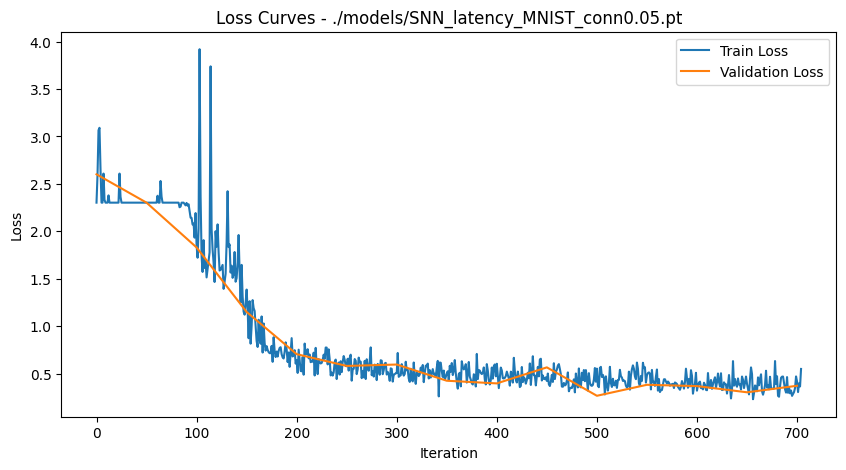

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 89.54%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 10.70
Validation loss: 9.64
Validation accuracy: 8.20%
Training accuracy: 8.20%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.11%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.32
Validation loss: 2.31
Validation accuracy: 8.20%
Training accuracy: 13.67%
----------------
Iteration: 150
Training loss: 1.77
Validation loss: 1.64
Validation accuracy: 46.48%
Training accuracy: 36.72%
----------------
Iteration: 200
Training loss: 0.89
Validation loss: 1.12
Validation accuracy: 68.75%
Training accuracy: 75.00%
----------------
Iteration: 250
Training loss: 0.68
Validation loss: 0.70
Validation accuracy: 80.08%
Training accuracy: 81.64%
----------------
Iteration: 300
Training loss: 0.80
Validation loss: 0.63
Validation accuracy: 83.59%
Training accuracy: 75.78%
----------------
Iteration: 350
Training loss: 0.48
Validation loss: 0.59
Validation accuracy: 80.08%
Training accuracy: 86.72

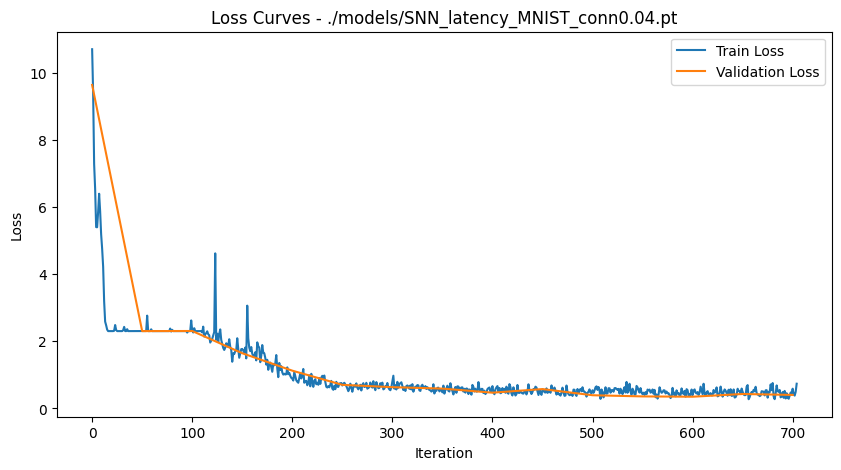

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 89.19%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 7.49
Validation loss: 7.70
Validation accuracy: 9.77%
Training accuracy: 8.59%
----------------
Iteration: 50
Training loss: 2.36
Validation loss: 2.36
Validation accuracy: 10.16%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.25
Validation loss: 2.34
Validation accuracy: 15.62%
Training accuracy: 17.97%
----------------
Iteration: 150
Training loss: 2.15
Validation loss: 2.00
Validation accuracy: 23.83%
Training accuracy: 21.09%
----------------
Iteration: 200
Training loss: 1.28
Validation loss: 1.32
Validation accuracy: 54.30%
Training accuracy: 59.77%
----------------
Iteration: 250
Training loss: 0.96
Validation loss: 0.90
Validation accuracy: 71.09%
Training accuracy: 68.36%
----------------
Iteration: 300
Training loss: 0.84
Validation loss: 0.83
Validation accuracy: 74.22%
Training accuracy: 74.22%
----------------
Iteration: 350
Training loss: 0.65
Validation loss: 0.70
Validation accuracy: 77.34%
Training accuracy: 81.25

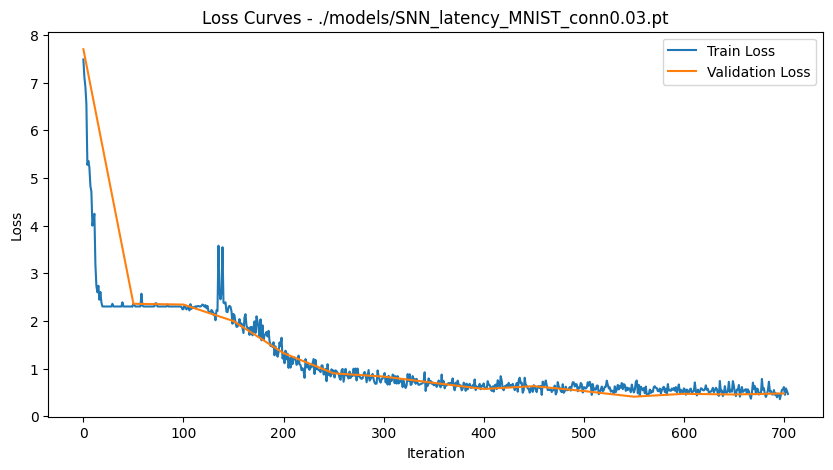

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 84.62%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 4.71
Validation loss: 2.55
Validation accuracy: 12.11%
Training accuracy: 7.03%
----------------
Iteration: 50
Training loss: 2.34
Validation loss: 2.30
Validation accuracy: 12.11%
Training accuracy: 12.11%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.38
Validation accuracy: 8.20%
Training accuracy: 12.11%
----------------
Iteration: 150
Training loss: 2.21
Validation loss: 2.28
Validation accuracy: 15.62%
Training accuracy: 15.62%
----------------
Iteration: 200
Training loss: 2.02
Validation loss: 1.99
Validation accuracy: 44.92%
Training accuracy: 47.27%
----------------
Iteration: 250
Training loss: 1.51
Validation loss: 1.33
Validation accuracy: 59.38%
Training accuracy: 53.91%
----------------
Iteration: 300
Training loss: 1.29
Validation loss: 1.23
Validation accuracy: 63.28%
Training accuracy: 57.03%
----------------
Iteration: 350
Training loss: 1.19
Validation loss: 1.14
Validation accuracy: 62.11%
Training accuracy: 62.89

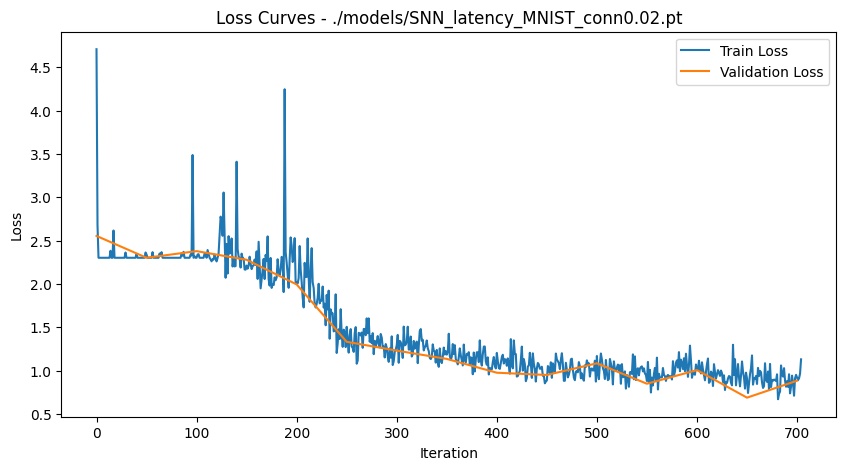

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 71.29%


Training progress::   0%|          | 0/705 [00:00<?, ?it/s]

Iteration: 0
Training loss: 8.34
Validation loss: 7.73
Validation accuracy: 7.81%
Training accuracy: 8.20%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.36
Validation accuracy: 10.16%
Training accuracy: 10.55%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.31
Validation accuracy: 15.23%
Training accuracy: 12.11%
----------------
Iteration: 150
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 10.55%
Training accuracy: 11.33%
----------------
Iteration: 200
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 6.25%
Training accuracy: 8.98%
----------------
Iteration: 250
Training loss: 2.31
Validation loss: 2.30
Validation accuracy: 10.55%
Training accuracy: 14.84%
----------------
Iteration: 300
Training loss: 2.33
Validation loss: 2.54
Validation accuracy: 11.33%
Training accuracy: 20.70%
----------------
Iteration: 350
Training loss: 2.48
Validation loss: 2.55
Validation accuracy: 19.53%
Training accuracy: 24.61%


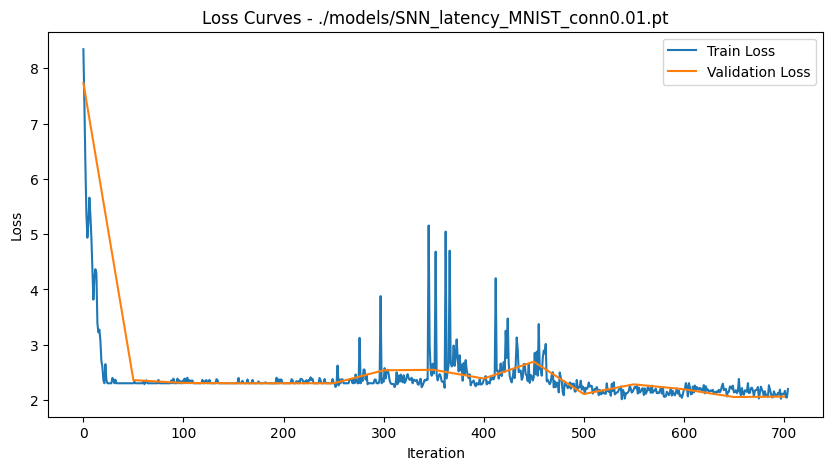

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 28.93%


In [4]:
#with and without deepr

#OK, BRUH, FOR SOME REASON, ONLY WITH LATENCY ENCODING, THE FIRST MODEL CREATED USING Net() JUST DOESNT TRAIN,
#BUT AFTER THAT IT DOES!! TF???
#I dont see anywhere in my model where im accidentally using some global state that could effect this

net = Net()

model_path = "./models/SNN_latency_MNIST.pt"
net = Net()
optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
gen_reset() #reset the PRNG generators for the random samplers so we consistently get the same sequence of samples for each experiment run
net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=3,deepr=False,device=device)
gen_reset()
baseline_accuracy = test_stats(net,test_loader=test_loader,device=device)
print("----")

connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]

accuracies = []

for c in connectivities:
    model_path = "./models/SNN_latency_MNIST_conn"+str(c)+".pt"
    net = Net(c)
    optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
    gen_reset()
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=3,deepr=True,device=device)
    gen_reset()
    a = test_stats(net,test_loader=test_loader,device=device)
    accuracies.append(a)

with open("./pickles/SNN_latency_MNIST_baseline", "wb") as f:
    pickle.dump(baseline_accuracy,f)

with open("./pickles/SNN_latency_MNIST_deepr_accuracies", "wb") as f:
    pickle.dump(accuracies,f)

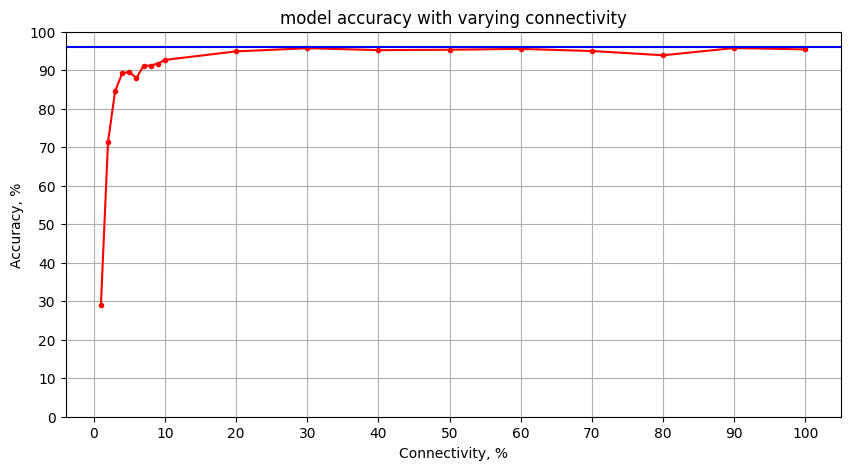

: 

In [5]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],[a*100 for a in accuracies],'.r-')
plt.axhline(y = baseline_accuracy*100, color = 'b', linestyle = '-')
plt.title("model accuracy with varying connectivity")
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy, %")
plt.xticks(range(0,101,10))
plt.yticks(range(0,101,10))
plt.grid(True)
plt.show()